In [ ]:
pip install mltu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.1 MB/s eta 0:00:00


In [ ]:
pip install tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 49.4 MB/s eta 0:00:00


In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.4 MB/s eta 0:00:00


In [ ]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 13.5 MB/s eta 0:00:00


In [ ]:
import os
from datetime import datetime

from mltu.configs import BaseModelConfigs

class ModelConfigs(BaseModelConfigs):
    def __init__(self):
        super().__init__()
        self.model_path = os.path.join("Models/04_sentence_recognition", datetime.strftime(datetime.now(), "%Y%m%d%H%M"))
        self.vocab = ""
        self.height = 96
        self.width = 1408
        self.max_text_length = 0
        self.batch_size = 32
        self.learning_rate = 0.0005
        self.train_epochs = 1000
        self.train_workers = 20

In [ ]:
from keras import layers
from keras.models import Model

from mltu.tensorflow.model_utils import residual_block


def train_model(input_dim, output_dim, activation="leaky_relu", dropout=0.2):

    inputs = layers.Input(shape=input_dim, name="input")

    # normalize images here instead in preprocessing step
    input = layers.Lambda(lambda x: x / 255)(inputs)

    x1 = residual_block(input, 32, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x2 = residual_block(x1, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x3 = residual_block(x2, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x4 = residual_block(x3, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x5 = residual_block(x4, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x6 = residual_block(x5, 128, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x7 = residual_block(x6, 128, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x8 = residual_block(x7, 128, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x9 = residual_block(x8, 128, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    squeezed = layers.Reshape((x9.shape[-3] * x9.shape[-2], x9.shape[-1]))(x9)

    blstm = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(squeezed)
    blstm = layers.Dropout(dropout)(blstm)

    blstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(blstm)
    blstm = layers.Dropout(dropout)(blstm)

    output = layers.Dense(output_dim + 1, activation="softmax", name="output")(blstm)

    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive');

FETCH THE SENTENCES TEXT PATH

In [ ]:
sentences_txt_path = "/content/drive/My Drive/Handwriting/Datasets/ascii/sentences.txt"

In [ ]:
# Ensure the file exists before trying to open it
if os.path.isfile(sentences_txt_path):
    # Open the file and read the contents
    with open(sentences_txt_path, 'r') as file:
        # Read the first few lines to confirm it's the correct file
        for i in range(5):  # Change the number to how many lines you want to read
            line = file.readline()
            print(line)
else:
    print("File not found. Make sure you have mounted your drive and the path is correct.")


FETCH THE DATABASE TEXT PATH

In [ ]:
# Define the path to the .tgz file and the target directory
sentences_folder_tgz = "/content/drive/My Drive/Handwriting/Datasets/sentences.tgz"
target_path = "/content/sentences"  # This is the directory in Colab's local environment where you want to extract the files

# Create the target directory if it doesn't exist
!mkdir -p "$target_path"

# Extract the .tgz file to the target directory
!tar -xvzf "$sentences_folder_tgz" -C "$target_path"

In [ ]:
!ls "$target_path"  # This will list the contents of the extracted directory

In [ ]:
sentences_folder_path = "/content/sentences"  # Local path in Colab where  extracted the .tgz file


print(sentences_folder_path)

In [ ]:
import os

# Check if the main directory exists
if os.path.isdir(sentences_folder_path):
    # Get all the entries in the directory
    all_folders = [folder for folder in os.listdir(sentences_folder_path) if os.path.isdir(os.path.join(sentences_folder_path, folder))]

    # Count all folders
    folder_count = len(all_folders)
    print(f"Total number of folders: {folder_count}")

    # Sort folders to get a consistent order
    all_folders.sort()

    # Get the first 5 and last 5 folders
    head_folders = all_folders[:5]
    tail_folders = all_folders[-5:]

    # Print first 5 folders
    print("First 5 subfolders:")
    for folder in head_folders:
        print(folder)

    # Print last 5 folders
    print("Last 5 subfolders:")
    for folder in tail_folders:
        print(folder)

else:
    print("Directory not found. Make sure you have mounted your drive and the path is correct.")


In [ ]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding, ImageShowCV2
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage

from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric



import os
from tqdm import tqdm

configs = ModelConfigs()

dataset, vocab, max_len = [], set(), 0
words = open(sentences_txt_path, "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[2] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = "-".join(line_split[0].split("-")[:2])
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip("\n")

    # replace "|" with " " in label
    label = label.replace("|", " ")

    rel_path = os.path.join(sentences_folder_path, folder1, folder2, file_name)
    if not os.path.exists(rel_path):
        print(f"File not found: {rel_path}")
        continue

    dataset.append([rel_path, label])
    vocab.update(list(label))
    max_len = max(max_len, len(label))

# Create a ModelConfigs object to store model configurations
configs = ModelConfigs()

# Save vocab and maximum text length to configs
configs.vocab = "".join(vocab)
configs.max_text_length = max_len
configs.save()

# Create a data provider for the dataset
data_provider = DataProvider(
    dataset=dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader(CVImage)],
    transformers=[
        ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
)



In [ ]:
# Split the dataset into training and validation sets
train_data_provider, val_data_provider = data_provider.split(split = 0.9)

# Augment training data with random brightness, rotation and erode/dilate
train_data_provider.augmentors = [
    RandomBrightness(),
    RandomErodeDilate(),
    RandomSharpen(),
    ]

# Creating TensorFlow model architecture
model = train_model(
    input_dim = (configs.height, configs.width, 3),
    output_dim = len(configs.vocab),
)

# Compile the model and print summary
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
    loss=CTCloss(),
    metrics=[
        CERMetric(vocabulary=configs.vocab),
        WERMetric(vocabulary=configs.vocab)
        ],
    run_eagerly=False
)
model.summary(line_length=110)



In [ ]:
# Define callbacks
earlystopper = EarlyStopping(monitor="val_CER", patience=20, verbose=1, mode="min")
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=5, verbose=1, mode="auto")
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")

# Train the model
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=1000,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx],
    workers=configs.train_workers
)

In [ ]:
import os
from PIL import Image

# Function to read and parse the labels file
def read_labels(labels_file_path):
    labels = {}
    with open(labels_file_path, 'r') as file:
        for line in file:
            if not line.startswith('#'):  # Skip comment lines
                parts = line.strip().split(' ')
                if len(parts) > 8:
                    image_id = parts[0]  # e.g., a01-000u-s00-00
                    transcription = ' '.join(parts[9:]).replace('|', ' ')
                    labels[image_id] = transcription
    return labels

# Your existing function to predict text from an image
def predict_text(image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Path to your dataset and labels
dataset_folder_path = '/content/drive/My Drive/Handwriting/Test'
sentences_txt_path = '/content/sentences.txt'

# Read labels
labels = read_labels(sentences_txt_path)

# Testing accuracy
correct_predictions = 0
total_images = 0

for image_id, truth in labels.items():
    image_path = os.path.join(dataset_folder_path, image_id + '.png')
    if os.path.exists(image_path):
        predicted_text = predict_text(image_path)
        print(f"Found: {image_path}")
        print(f"Predicted: {predicted_text}, Ground Truth: {truth}")
        if predicted_text == truth:
            correct_predictions += 1
        total_images += 1
    else:
        print(f"Image not found: {image_path}")


accuracy = correct_predictions / total_images if total_images > 0 else 0
print(f" Accuracy: {accuracy * 100}%")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/Handwriting/export/model.zip'
extraction_path = '/content/extracted_folder'  # Change to your desired extraction path


from transformers import TrOCRProcessor, VisionEncoderDecoderModel


processor = TrOCRProcessor.from_pretrained('/content/drive/MyDrive/Handwriting/export/processor')


import zipfile

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

model = VisionEncoderDecoderModel.from_pretrained('/content/extracted_folder/model')


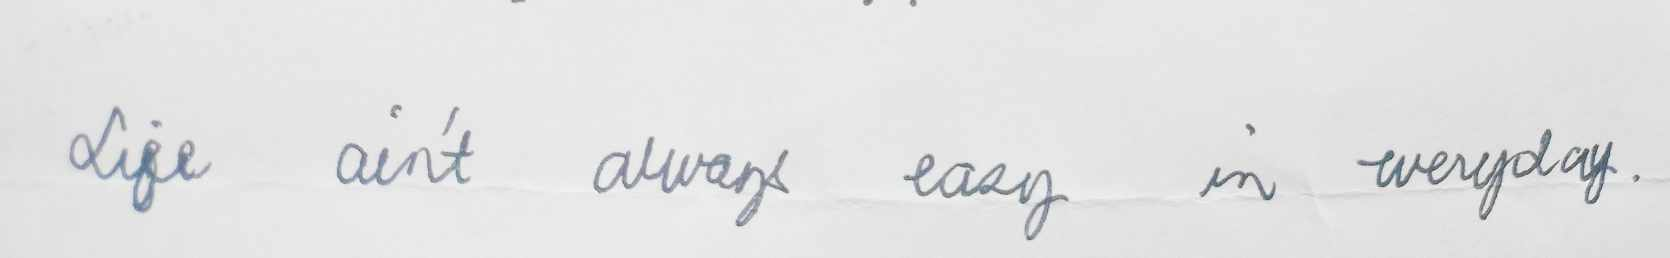

"dige ain't away easy in everyday."

In [ ]:
from IPython.display import Image, display

image_path = '/content/drive/MyDrive/Handwriting/testing/Testing/9th.jpg'

display(Image(filename=image_path))

from PIL import Image


def predict_text(image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]


predict_text(image_path)

In [ ]:
eval_dataset = [
    ('/content/drive/MyDrive/Handwriting/testing/Testing/10th.jpg', 'because we all mess up sometimes.'),
    ('/content/drive/MyDrive/Handwriting/testing/Testing/11th.jpg', 'I will never forget you.'),
    ('/content/drive/MyDrive/Handwriting/testing/Testing/12th.jpg', 'on second thought.'),
    ('/content/drive/MyDrive/Handwriting/testing/Testing/13th.jpg', 'you still remember my name.'),
    ('/content/drive/MyDrive/Handwriting/testing/Testing/14th.jpg', 'I need to talk to you.'),
    ('/content/drive/MyDrive/Handwriting/testing/Testing/15th.jpg', 'The world is changing.'),
    ('/content/drive/MyDrive/Handwriting/testing/Testing/16th.jpg', 'manifesting! thesis Defended.!!'),
    ('/content/drive/MyDrive/Handwriting/testing/Testing/17th.jpg', 'imperfection is beauty.'),
    ('/content/drive/MyDrive/Handwriting/testing/Testing/1st.jpg', 'Therefore , I conclude that life is easy'),
    ('/content/drive/MyDrive/Handwriting/testing/Testing/2nd.jpg', "I don't think so."),
    ('/content/drive/MyDrive/Handwriting/testing/Testing/3rd.jpg', 'However, and otherwise'),
    ('/content/drive/MyDrive/Handwriting/testing/Testing/4th.jpg', 'then again!'),
      ('/content/drive/MyDrive/Handwriting/testing/Testing/5th.jpg', 'This is a handwritten sample.'),
    ('/content/drive/MyDrive/Handwriting/testing/Testing/6th.jpg', 'many might have been waiting outside for you.'),
      ('/content/drive/MyDrive/Handwriting/testing/Testing/7th.jpg', 'she helped to build the roof.'),
     ('/content/drive/MyDrive/Handwriting/testing/Testing/8th.jpg', 'Just so you know.'),
]


In [ ]:
from datasets import load_metric

# Load WER and CER metrics
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

# Evaluation loop
for image_path, true_text in eval_dataset:
    # Load the image from the file path
    image = Image.open(image_path).convert("RGB")

    # Preprocess the image
    inputs = processor(image, return_tensors="pt")

    # Generate prediction
    outputs = model.generate(inputs["pixel_values"])

    # Decode the prediction
    pred_text = processor.batch_decode(outputs, skip_special_tokens=True)[0]

    print(pred_text)
    # Calculate WER and CER
    wer_metric.add_batch(predictions=[pred_text], references=[true_text])
    cer_metric.add_batch(predictions=[pred_text], references=[true_text])

# Compute final WER and CER
final_wer = wer_metric.compute()
final_cer = cer_metric.compute()

print(f"WER: {final_wer}, CER: {final_cer}")

<ipython-input-27-5b0ef4b83247>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


because we all mess up sometimes.
I will never forget you.
on second thought.
you still remember my name.
I need to talk to you.
The world is changing.
manifesting! thesis Depended. 1.
imperfection is beauty.
There were 12 conclude that life is easy
I don't think so.
However, and otherwise
then again!
This is a handwritten sample.
many might have been waiting outside for you.
she helped to build the roof.
That so you know.
WER: 0.08, CER: 0.03170731707317073
